# Helper functions

In [1]:
# # free port 6006 for tensorboard
# !fuser 6006/tcp -k

# Colab

In [ ]:
# Check if you are in Google Colab or not
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
if IN_COLAB:
    import json
    import os

    # packages
    !pip install -q segmentation-models-pytorch
    !pip install -q torchsummary
    !pip install pytorch-adapt

    # mount drive
    from google.colab import drive
    drive.mount('/content/drive')

    # copy deploy keys
    !mkdir -p /root/.ssh/ && cp /content/drive/MyDrive/Bennett/Bennett_Colab/deploy_keys/id_ed25519* /root/.ssh/

    # add github as trusted entity
    !ssh-keyscan github.com >> /root/.ssh/known_hosts

    # test authentication
    !ssh -T git@github.com

    # clone private repo
    !git clone git@github.com:bempt/adversarial_UDA_2.git

    # Get the current directory
    current_dir = os.getcwd()

    # Check if the current directory is not '/content/Adversarial_UDA'
    if current_dir != '/content/adversarial_UDA_2':
        # Change to the '/content/Adversarial_UDA' directory
        os.chdir('/content/adversarial_UDA_2')

    # make checkpoints dir
    !mkdir -p checkpoints/adversarial
    !mkdir -p checkpoints/segmentation

    # download data
    kaggle_token = 'kaggle.json'
    with open(kaggle_token, "w") as f:
                json.dump({"username":"bennettnewhook",
                           "key":"d4d6dbe590ee043d03d95e86dde3ef43"}, f)
    !rm -r ~/.kaggle
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d bulentsiyah/semantic-drone-dataset

    # unzip data
    UNZIP_PATH = './data/semantic-drone/'
    !mkdir -p {UNZIP_PATH}
    !unzip -q semantic-drone-dataset.zip -d {UNZIP_PATH}

# Holyrood
# symlink stored under school/research/bennett_datasets

# Helper functions

In [3]:
# free port 6006 for tensorboard
!fuser 6006/tcp -k

# Setup

In [4]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.0+cu117
torchvision version: 0.15.1+cu117


In [5]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [6]:
from modular.utils import set_device, set_seeds

device = set_device()
seed = set_seeds()

2023-04-15 09:02:15.109521: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 09:02:16.015696: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[INFO] Using cuda device
[INFO] Set random seed to: 42


# Params

In [1]:
# Data
SUP_VAL_SPLIT = 0.15
SUP_TEST_SPLIT = 0.1
SUP_IMAGE_PATH = './data/semantic-drone/dataset/semantic_drone_dataset/original_images/'
SUP_MASK_PATH = './data/semantic-drone/dataset/semantic_drone_dataset/label_images_semantic/'

# Model
## Segmentation
### Pretrained
BACKBONE = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = None
ENCODER_DEPTH = 5
DECODER_CHANNELS = [256, 128, 64, 32, 16]
MEAN=[0.485, 0.456, 0.406]
STD=[0.229, 0.224, 0.225]
### Optimizer
MAX_LR = 1e-3
WEIGHT_DECAY = 1e-4

# Train
EPOCHS = 2
BATCH_SIZE = 2
NUM_WORKERS_RATIO = 0.6

# Model Save Path
if IN_COLAB:
    MODEL_SAVE_PATH = '/content/drive/MyDrive/Bennett/Bennett_Colab/adversarial_UDA_2/checkpoints/segmentation/'
else:
    MODEL_SAVE_PATH = './checkpoints/segmentation/'

SyntaxError: incomplete input (21509945.py, line 31)

# Data

Total images:  400
Train Size   :  306
Val Size     :  54
Test Size    :  40
Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


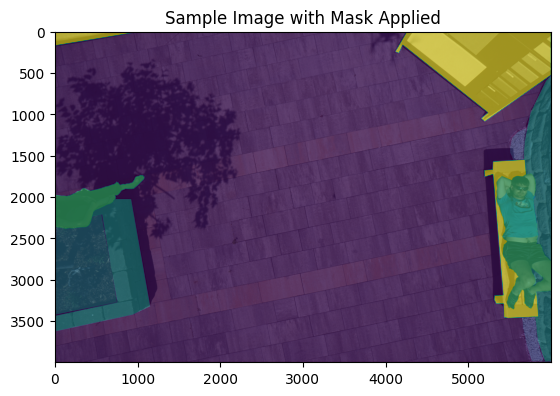

In [8]:
from modular.segmentation import data_setup_segmentation

# Split data
sup_df, sup_img_count = data_setup_segmentation.create_df(SUP_IMAGE_PATH)
X_trainval, X_test, X_train, X_val = data_setup_segmentation.split_data_supervised(sup_df, SUP_VAL_SPLIT, SUP_TEST_SPLIT, seed)
data_setup_segmentation.data_size(sup_img_count, X_train, X_val, X_test)

# Sample image and mask
example_file_id = 100
data_setup_segmentation.mask_over_image(sup_df, example_file_id, SUP_IMAGE_PATH, SUP_MASK_PATH)

In [9]:
from torch.utils.data import Dataset, DataLoader
from modular.segmentation import data_setup_segmentation as seg_data
import os

train_set_seg, val_set_seg, test_set_seg = seg_data.make_datasets(SUP_IMAGE_PATH, SUP_MASK_PATH,
                                                                  X_train, X_val, X_test,
                                                                  MEAN, STD,
                                                                  seg_data.t_train, seg_data.t_val, seg_data.t_test,
                                                                  )

train_loader_seg, val_loader_seg, test_loader_seg = seg_data.make_dataloaders(train_set_seg, val_set_seg, test_set_seg,
                                                                          BATCH_SIZE,
                                                                          NUM_WORKERS_RATIO,
                                                                          )

# Single Model

## Model

In [10]:
import segmentation_models_pytorch as smp

seg_model = smp.Unet(BACKBONE,
                    encoder_weights=ENCODER_WEIGHTS,
                    classes=seg_data.N_CLASSES,
                    activation=ACTIVATION,
                    encoder_depth=ENCODER_DEPTH,
                    decoder_channels=DECODER_CHANNELS
                    ).to(device)

# View the output of the model
# seg_model

In [11]:
# Define loss and optimizer
loss_seg = nn.CrossEntropyLoss()
optimizer_seg = torch.optim.AdamW(seg_model.parameters(),
                                            lr=MAX_LR,
                                            weight_decay=WEIGHT_DECAY
                                            )

In [12]:
# # Freeze all base layers by setting requires_grad attribute to False
# for param in model.features.parameters():
#     param.requires_grad = False
    
# # Since we're creating a new layer with random weights (torch.nn.Linear), 
# # let's set the seeds
# set_seeds() 

# # Update the classifier head to suit our problem
# model.classifier = torch.nn.Sequential(
#     nn.Dropout(p=0.2, inplace=True),
#     nn.Linear(in_features=1280, 
#               out_features=len(class_names),
#               bias=True).to(device))

In [13]:
# from torchinfo import summary

# # # Get a summary of the model (uncomment for full output)
# summary(seg_model, 
#         input_size=(BATCH_SIZE, 3, 256, 256), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
#         verbose=0,
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

In [14]:
import modular.segmentation.model_builder_segmentation as seg_builder

disc_model = seg_builder.create_discriminator()

[INFO] Using cuda device
[INFO] Set random seed to: 42
[INFO] Created new discriminator model.


## Train

In [15]:
import modular.segmentation.engine_segmentation as engine_segmentation
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

In [16]:
model_name = "unet_resnet50"
save_filepath = f"07_{model_name}_{EPOCHS}_epochs.pth"

if __name__ == '__main__': # prevents the crashing of multiprocessing (num_workers_ratio)
    seg_results = engine_segmentation.train(model=seg_model,
                    train_dataloader=train_loader_seg,
                    val_dataloader=val_loader_seg,
                    optimizer=optimizer_seg,
                    loss_fn=loss_seg,
                    epochs=EPOCHS,
                    device=device,
                    writer=writer,
                    target_dir=MODEL_SAVE_PATH,
                    model_name=save_filepath
                    )

  0%|          | 0/153 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3546bdf010>
Traceback (most recent call last):
  File "/home/bennett/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/bennett/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/bennett/anaconda3/envs/tensorflow_env/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/bennett/anaconda3/envs/tensorflow_env/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/bennett/anaconda3/envs/tensorflow_env/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/bennett/anaconda3/envs/tensorflow_e

OutOfMemoryError: CUDA out of memory. Tried to allocate 92.00 MiB (GPU 0; 1.96 GiB total capacity; 1.12 GiB already allocated; 64.25 MiB free; 1.15 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Experiments

## Setup

In [18]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

NameError: name 'download_data' is not defined

In [ ]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

In [ ]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [ ]:
# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup_multiclass_food.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup_multiclass_food.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

In [ ]:
import modular.multiclass_food.model_builder_multiclass_food as model_builder_multiclass_food

out_features = len(class_names)

effnetb0 = model_builder_multiclass_food.create_effnetb0(out_features) 
effnetb2 = model_builder_multiclass_food.create_effnetb2(out_features)

# # Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
# summary(model=effnetb0, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

## Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

## Definition

In [ ]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

# Train

In [ ]:
%%time

from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

from modular.utils import save_model, create_writer

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = model_builder.create_effnetb0(out_features) # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = model_builder.create_effnetb2(out_features) # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            engine.train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

In [ ]:
# check results in tensorboard
# ## will error in VS Code, have to SHIFT CMD P and search for Python: Launch TensorBoard
# %load_ext tensorboard # line magic to load TensorBoard
# %tensorboard --logdir runs # run TensorBoard session with the "runs/" directory

# Load best model, predictions